# Cascaded Tanks Incremental Update

The purpose of this note book is to break the ingestion of data from the experiment into multiple updates of the model.  Currently, the issue that is being ran into is that when making predictions in the future, there are points (near data point 1800) where the error is just so large that the input space (which is changing since it is dependant on the integration) goes beyond the training data, including adding a pillow of 50% in the positive direction, when training on the first 1000 data points. This creates some issues with the model as a whole since we can't get predictions, we can't get an RSME either.  So, I trained on the last 1000 data points since it had a better wholistic representation of the data, but this is an error that needs to be explored further.

## Part 1: Preprocessing Data

This is the same as in the first notebook.

In [8]:
# Import relevant libraries

# Data Processing
import pandas as pd
import numpy as np

# Modeling
from FoKL import FoKLRoutines

# Visualizations
import matplotlib.pyplot as plt

# Load in data
tank1 = pd.read_csv('data/tank1.csv')

## Part 2: Modeling
For this part, we are training on the last 1000 data points since the first 1000 gave issues.

In [9]:
# Create Models for the derivatives of h1 and h2

GP_dh1_model1 = FoKLRoutines.FoKL(UserWarnings=False, draws = 500, tolerance = 1)
GP_dh1_model1.update = True # To use update methodology, must be called PRIOR to first fitting
GP_dh1_model1.built = False # Defines whether fresh model is created or prior model used
_ = GP_dh1_model1.fit(inputs = [tank1[['h1','h2','u']].iloc[:1000]], 
           data = tank1['h1_der'].iloc[:1000], 
           clean = True,
           minmax = [[0,10],[0,10],[0,3]]) 

GP_dh2_model1 = FoKLRoutines.FoKL(UserWarnings=False, draws = 500, tolerance = 1)
GP_dh2_model1.update = True # To use update methodology, must be called PRIOR to first fitting
GP_dh2_model1.built = False # Defines whether fresh model is created or prior model used
_ = GP_dh2_model1.fit(inputs = [tank1[['h1','h2','u']].iloc[:1000]], 
           data = tank1['h2_der'].iloc[:1000], 
           clean = True,
           minmax = [[0,10],[0,10],[0,3]])

1 -8467.800167833902
2 -8779.822241761613
2 -8903.989737272419
3 -9350.2523784292
3 -9486.70327068014
4 -9507.37829638219
4 -9536.094635470492
4 -9617.803941038834
5 -9579.738304113118
5 -9645.940128421431
5 -9684.60508374666
6 -9662.85469101025
6 -9646.726227173504
1 -9144.206958242925
2 -9494.105846418015
2 -9708.77947241757
3 -9955.361628609138
3 -10099.241724573667
4 -10109.23391562263
4 -10078.73201760529
4 -10046.729785966312


Now, let's use the forward Euler's method (Code from Jacob Krell).

In [10]:
# Create vector of times and pump signals
tvec = tank1["time"].values
u = tank1['u'].values
# Create blank vectors for h1 and h2 values
h1 = np.zeros_like(tvec, dtype=float)
h2 = np.zeros_like(tvec, dtype=float)

# Initial Conditions
h1[0] = tank1["h1"].values[0]
h2[0] = tank1["h2"].values[0]
# Integration using forward Euler
for i in range(len(tvec) - 1):
    h1[i] = np.clip(h1[i], GP_dh1_model1.minmax[0][0], GP_dh1_model1.minmax[0][1])
    h2[i] = np.clip(h2[i], GP_dh1_model1.minmax[1][0], GP_dh1_model1.minmax[1][1])
    h1[i + 1] = h1[i] + 5 * GP_dh1_model1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True)
    h2[i + 1] = h2[i] + 5 * GP_dh2_model1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True)
    
    if i % 250 == 0:
        print(i)

tank1['h1_prediction'] = h1
tank1['h2_prediction'] = h2

0


C:\Users\Michael\AppData\Local\Temp\ipykernel_20380\4053090582.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h1[i + 1] = h1[i] + 5 * GP_dh1_model1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_20380\4053090582.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h2[i + 1] = h2[i] + 5 * GP_dh2_model1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True)


250
500
750
1000
1250
1500
1750
2000
2250


Now, let's visualize the predictions.

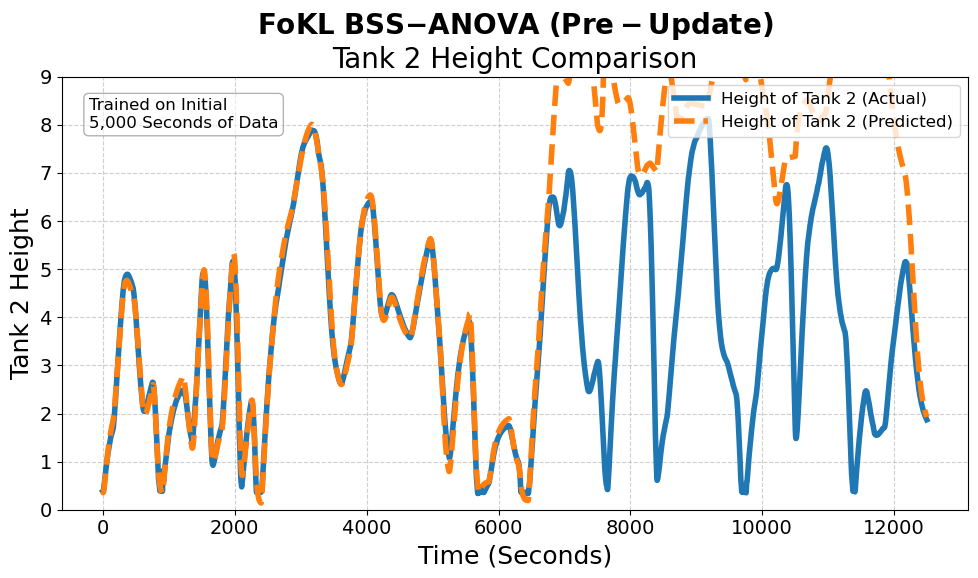

In [11]:
# Plot with improved aesthetics
plt.rcParams.update({'font.size': 14})  # Adjust the number to increase/decrease font size
fig, ax = plt.subplots(figsize=(10, 6))

# Plot both the actual and predicted data
ax.plot(tank1['time'], tank1['h2'], label='h1', linewidth=4, linestyle='-')#, color='blue')
ax.plot(tank1['time'], tank1['h2_prediction'], label='h2_prediction', linewidth=4, linestyle='--')#, color='red')

# Enhancing the graph with titles, labels, and grid
ax.set_title(r'$\bf{FoKL\ BSS{-}ANOVA\ (Pre-Update)}$' + '\nTank 2 Height Comparison', fontsize=20)
ax.set_xlabel('Time (Seconds)', fontsize=18)
ax.set_ylabel('Tank 2 Height', fontsize=18)
ax.legend(['Height of Tank 2 (Actual)', 'Height of Tank 2 (Predicted)'], fontsize=12, loc='upper right')

ax.grid(True, linestyle='--', alpha=0.6)

# ax.text(-250, 7, 'Trained on Initial \n10,000 Seconds of Data', fontsize=12, color='black', bbox = dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4', alpha = 0.6))

# Add a note in the upper-left corner with a rounded box
ax.text(0.03, 0.95, 'Trained on Initial \n5,000 Seconds of Data',
        fontsize=12, color='black',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3', alpha = 0.6),
        transform=ax.transAxes,  # Use normalized coordinates
        verticalalignment='top',  # Align text to the top of the box
        horizontalalignment='left')  # Align text to the left

ax.set_ylim(0, 9)

# Show plot
plt.tight_layout()
plt.show()

# Update Model
Now, lets update the model.

In [12]:
# Create Models for the derivatives of h1 and h2
GP_dh1_model1.inputs = GP_dh1_model1.clean(tank1[['h1','h2','u']].iloc[1000:2000].to_numpy().tolist())
data_test = tank1['h1_der'].iloc[1000:2000].to_numpy()
GP_dh1_model1.data = np.expand_dims(data_test, axis = 0).T

# Second fitting
_ = GP_dh1_model1.fit()

# Create Models for the derivatives of h1 and h2
GP_dh2_model1.inputs = GP_dh2_model1.clean(tank1[['h1','h2','u']].iloc[1000:2000].to_numpy().tolist())
data_test = tank1['h2_der'].iloc[1000:2000].to_numpy()
GP_dh2_model1.data = np.expand_dims(data_test, axis = 0).T

# Second fitting
_ = GP_dh2_model1.fit()

same
5 -9486.499191175146
new
6 -7502.5566893762
new
6 -7465.4389486419195
same
4 -10376.687181066463
new
4 -9911.53345403305
new
4 -9988.031676441104


In [13]:
# Create vector of times and pump signals
tvec = tank1["time"].values
u = tank1['u'].values
# Create blank vectors for h1 and h2 values
h1 = np.zeros_like(tvec, dtype=float)
h2 = np.zeros_like(tvec, dtype=float)

# Initial Conditions
h1[0] = tank1["h1"].values[0]
h2[0] = tank1["h2"].values[0]
# Integration using forward Euler
for i in range(len(tvec) - 1):
    h1[i] = np.clip(h1[i], GP_dh1_model1.minmax[0][0], GP_dh1_model1.minmax[0][1])
    h2[i] = np.clip(h2[i], GP_dh1_model1.minmax[1][0], GP_dh1_model1.minmax[1][1])
    h1[i + 1] = h1[i] + 5 * GP_dh1_model1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True)
    h2[i + 1] = h2[i] + 5 * GP_dh2_model1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True)
    
    if i % 250 == 0:
        print(i)

tank1['h1_prediction'] = h1
tank1['h2_prediction'] = h2

0


C:\Users\Michael\AppData\Local\Temp\ipykernel_20380\4053090582.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h1[i + 1] = h1[i] + 5 * GP_dh1_model1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_20380\4053090582.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h2[i + 1] = h2[i] + 5 * GP_dh2_model1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True)


250
500
750
1000
1250
1500
1750
2000
2250


In [14]:
MSE = np.sum((tank1['h2'][2000:-1] - tank1['h2_prediction'][2000:-1])**2)/len(tank1)
MSE

0.014429269801822622

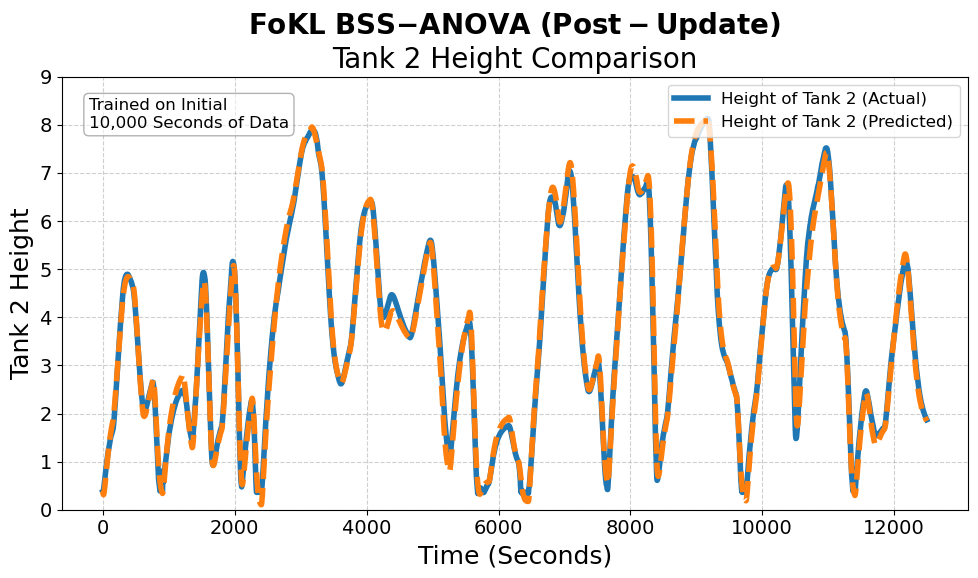

In [15]:
# Plot with improved aesthetics
plt.rcParams.update({'font.size': 14})  # Adjust the number to increase/decrease font size
fig, ax = plt.subplots(figsize=(10, 6))

# Plot both the actual and predicted data
ax.plot(tank1['time'], tank1['h2'], label='h1', linewidth=4, linestyle='-')#, color='blue')
ax.plot(tank1['time'], tank1['h2_prediction'], label='h2_prediction', linewidth=4, linestyle='--')#, color='red')

# Enhancing the graph with titles, labels, and grid
ax.set_title(r'$\bf{FoKL\ BSS{-}ANOVA\ (Post-Update)}$' + '\nTank 2 Height Comparison', fontsize=20)
ax.set_xlabel('Time (Seconds)', fontsize=18)
ax.set_ylabel('Tank 2 Height', fontsize=18)
ax.legend(['Height of Tank 2 (Actual)', 'Height of Tank 2 (Predicted)'], fontsize=12, loc='upper right')

ax.grid(True, linestyle='--', alpha=0.6)

# ax.text(-250, 7, 'Trained on Initial \n10,000 Seconds of Data', fontsize=12, color='black', bbox = dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4', alpha = 0.6))

# Add a note in the upper-left corner with a rounded box
ax.text(0.03, 0.95, 'Trained on Initial \n10,000 Seconds of Data',
        fontsize=12, color='black',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3', alpha = 0.6),
        transform=ax.transAxes,  # Use normalized coordinates
        verticalalignment='top',  # Align text to the top of the box
        horizontalalignment='left')  # Align text to the left

ax.set_ylim(0, 9)

# Show plot
plt.tight_layout()
plt.show()